# Problem 1: (50% for CSC 446, 50% for CSC 546)

To ensure that you read and fully understand the template source code for discrete-event simulation of single-queue-single-server systerm, translate the sample Jave code posted in Brightspace--Content--Weeks 2,3 to Python. **Note that you are not allowed to use existing python function to generate exponential or normal variates.**

Using the given default parameters given in the sample code, generate 400 customers, and record their arrival times, departure times, service times, and waiting times in the queue in the following format:

| Customer #  | Arrival Time      |  Departure Time | Service Time for the Customer| The Customer's Waiting Time in the Queue|
|:---------------------:|:------------:|:-------------|:----------:|:-----|






In [10]:
''' Write your Python source code is below
'''
 
import random
import numpy as np
import prettytable #used to format problem 1 output
import sys

## create event class:
#note: event has only one parameter for data so that when searching, the correct instance of (eventtype, time) will be returned, 
# because it is possible for two events of different types to be happening at the same time.
#Note: eventtype has two options: 'A' or 'D'. python is fun and will let us compare characters, so arrivals<departures and are serviced first, just like sample code.
class Event:
    def __init__(self, event_type, time, num=-1): 
        #default num is -1 because we're only using num for arrival events
        self.data = (event_type, time) #data = (type, time)
        self.num = num
        self.parent = None
        self.left = None #left child
        self.right = None #right child
    def get_type(self):
        return self.data[0]
    def get_time(self):
        return self.data[1]


'''Event list is an instance of splay trees, so create a splay tree class:
# In this case, the data of interest stored at each node is the time, which is referenced by data[1]. 
# however, in the case that two events of different types occur at the same time, they are sorted in alphabetical order (ie. arrivals before departures).
# note: I kept the variable "node" instead of "event" so that this code can easily be repurposed later.
#Implementation of splay tree adapted from https://github.com/Bibeknam/algorithmtutorprograms/blob/master/data-structures/splay-trees/splay_tree.py
#   Author: AlgorithmTutor
#   Tutorial URL: URL: http://algorithmtutor.com/Data-Structures/Tree/Splay-Trees/
#methods from the tutorial not included for this implementation: __print_helper(), pretty_print(), __pre_order_helper(), preorder(), __post_order_helper(), postorder(), successor(), predecessor()
'''

class SplayTree:
    def __init__(self):
        self.root = None
    
    #helping operation for search_tree function. returns the event(node) with data 'key'
    def __search_tree_helper(self, node, key):
        if node == None or key == node.data:
            return node
        #if node != key, then compare times.
        if key[1] < node.data[1]:
            return self.__search_tree_helper(node.left, key)
        elif key[1] > node.data[1]:
            return self.__search_tree_helper(node.right, key)
        #if here, then times are =, but event type is not
        elif key[0] < node.data[0]: #key is arrival and node is departure, so key is to left of node.
            return self.__search_tree_helper(node.left, key) 
        return self.__search_tree_helper(node.right,key)
    
    #helping operation for delete_node function
    def __delete_node_helper(self,node,key):
        x = None
        t = None
        s = None
        #find node with data 'key' and assign it to x
        while node != None:
            if node.data == key:
                x = node
            #reassign that node to one of it's children, depending on key
            if node.data[1] < key[1]:
                node = node.right
            elif node.data[1] > key[1]:
                node = node.left
            elif node.data[0] <= key[0]:
                node = node.right
            else:
                node = node.left
        if x==None:
            print("uh oh! couldn't find key in the tree")
            return
        #perform split operation at x. now t=x's right children, s=x and it's left children
        self.__splay(x)
        if x.right != None:
            t=x.right
            t.parent = None
        else:
            t = None
        s = x
        s.right = None
        x = None
        #join s's left child (aka x's left child) to t
        if s.left != None:
            s.left.parent = None
        #the tree has been joined back together, with x deleted, and t as the new root.
        self.root = self.__join(s.left, t)
        s = None

    #Operation: rotate left at node x (aka ZAG)
    def __left_rotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != None:
            y.left.parent = x
        
        y.parent = x.parent
        if x.parent == None:
            self.root = y
        elif x == x.parent.left:
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    #Operation: rotate right at node x (aka ZIG)
    def __right_rotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != None:
            y.right.parent = x
		
        y.parent = x.parent;
        if x.parent == None:
            self.root = y
        elif x == x.parent.right:
            x.parent.right = y
        else:
            x.parent.left = y
		
        y.right = x
        x.parent = y

    #Operation: Splay. moves x to the root of the tree
    def __splay(self,x):
        while x.parent != None: #check x isn't already the root
            if x.parent.parent == None: #x does not have grandparent (ie. must be on level 1)
                if x == x.parent.left: #x is left child on level 1
                    #perform ZIG
                    self.__right_rotate(x.parent)
                else:
                    #perform ZAG
                    self.__left_rotate(x.parent)
            elif x==x.parent.left and x.parent==x.parent.parent.left: #x is leftmost grandchild on level i<1 (x<parent<grandparent)
                #perform ZIG-ZIG
                self.__right_rotate(x.parent.parent)
                self.__right_rotate(x.parent)
            elif x==x.parent.right and x.parent==x.parent.parent.right: #x is rightmost grandchild on level i>1 (grandparent<parent<x)
                #perform ZAG-ZAG
                self.__left_rotate(x.parent.parent)
                self.__left_rotate(x.parent)
            elif x==x.parent.right and x.parent==x.parent.parent.left: # (x > parent < grandparent)
                #perform ZIG-ZAG
                self.__left_rotate(x.parent)
                self.__right_rotate(x.parent)
            else: # (grandparent < x < parent)
                #perform ZAG-ZIG
                self.__right_rotate(x.parent)
                self.__left_rotate(x.parent)
    
    #Operation: Join. joins two trees s and t (assuming s>t)
    def __join(self, s, t):
        #if s or t are empty, return the other tree.
        if s==None: return t
        if t==None: return s

        #find maximum of s, and set that to be the root
        x = self.maximum(s)
        self.__splay(x)
        #set t to be the right child of s (now x)
        x.right = t
        t.parent = x
        return x
    
    #helping function for inorder(). Prints the datas in subtree rooted at node in increasing data. (left subtree -> node -> right subtree)
    #I MIGHT NOT EVEN NEED THIS ONE?? if i do probably will need to modify it so it doesn't print
    def __in_order_helper(self, node):
        if node != None:
            self.__in_order_helper(node.left)
            sys.stdout.write(node.data[0] + str(node.data[1]) + " ")
            self.__in_order_helper(node.right)
    
    #Pre-Order Traversal of splay tree (ie. increasing data)
    def inorder(self):
        self.__in_order_helper(self.root)

    #Operation: Search(k). Search tree for key k, return the node with data=k.
    #lol honestly might not even need this one???
    def search_tree(self, k):
        x = self.__search_tree_helper(self.root, k)
        if x!=None:
            #splay the tree after searching such that the node w data k is at the root.
            self.__splay(x)
    
    #Operation: Minimum. Return node with the smallest data
    #I'M CHANGING IT to always start from the root.
    def minimum(self):#, node):
        node = self.root
        while node.left != None:
            node = node.left
        return node
    
    #Operation: FindMax. return node w max data
    def maximum(self, node):
        while node.right != None:
            node = node.right
        return node

    #Operation: Insert. Insert a new node into the splay tree.
    #note: I modified this one so it's inserting the node w/ data=key, rather than just inserting the key (and having to make a new node)
    def insert(self, node):
        y = None
        x = self.root

        while x!=None:
            y=x
            if node.data[1] < x.data[1]:
                x = x.left
            elif node.data[1] > x.data[1]:
                x = x.right
            elif node.data[0] < x.data[0]:
                x = x.left
            else:
                x = x.right
        
        #now y is parent of x
        #insert node so that it's a child of y and sort accordingly wrt y
        node.parent = y
        if y == None:
            self.root = node
        elif node.data[1] < y.data[1]:
            y.left = node
        elif node.data[1] > y.data[1]:
            y.right = node
        elif node.data[0] < y.data[0]:
            y.left = node
        else:
            y.right = node
        #splay after insertion so that now node is the root
        self.__splay(node)


    #Operation: Delete. Delete the node with key 'data' from the tree
    #I'M CHANGING IT to delete the node 'node' from tree. Will still send node.data to helper func tho
    #^^^^ JK NO I'M NOT (unless it doesnt work?)
    def delete_node(self, data):
        self.__delete_node_helper(self.root, data)


    #FOR TESTING: draw the trees :)
    def __print_helper(self, currPtr, indent, last):
		# print the tree structure on the screen
        if currPtr != None:
            sys.stdout.write(indent)
            if last:
                sys.stdout.write("R----")
                indent += "     "
            else:
                sys.stdout.write("L----")
                indent += "|    "

            print(currPtr.data)

            self.__print_helper(currPtr.left, indent, False)
            self.__print_helper(currPtr.right, indent, True)

    # print the tree structure on the screen
    def pretty_print(self):
        self.__print_helper(self.root, "", True)

## create customer queue
#FIFO queue implemented via python list.
    #enqueue: list.append() (ie. adds to end of list)
    #dequeue: list.pop(0)   (ie. deletes and returns first item)
    #note: the items in the list are Event objects.


#create Sim class ONLY for use of class variables and class data structures. init them here as well:
#Since we are only doing one run, we refer to the class variables as Sim.variable
# and don't create a specific object sim=Sim(). 
# (for future use: create the object in the 'if __name__==__main__' part before calling main(), and then change code to reference that object.)

#REMEMBER TO CHANGE TO 400 CUSTOMERS
class Sim:
    #sim parameters (constant for the given system).
    #Using default parameters from Sim.java source code, except with 400 customers.
    MeanInterArrivalTime = 4.5
    MeanServiceTime = 3.2
    SIGMA = 0.6
    TotalCustomers = 400
    #simulation data structures:
    Customers = []
    FEL = SplayTree()
    #initialize rest of class variables
    Clock = 0.0
    QueueLength = 0
    NumberInService = 0
    LastEventTime = 0.0
    TotalBusy = 0 
    MaxQueueLength = 0
    SumResponseTime = 0
    NumberOfDepartures = 0
    LongService = 0         
    NumberofCustomers = 1 #counter for customers, increment before each new arrival evt
    #class variables for normal RV generation:
    NumNormals = 0
    SaveNormal = 0
    #customer lists for report generation at end:
    #   Arrival and departure events always get processed in order (ie. A1,A2,.. and D1,D2,...) 
    #   so can just append times to arrivaltime and departtime lists as they are processed.
    CustNumList = []#i for i in range(1,401)] 
    ArrivalTime = []
    DepartTime = []
    ServiceTimeCust = []
    QueueWaitTime = []
    ResponseTime = []


## ---------MAIN BODY----------
def main():
    
    ##1. Initialization:
    #initialize data structures and rng stream
    random.seed(10) #gives same sequence of random values each time

    #create and add first arrival event
    evt = Event('A', exponentialRV(random.random(), Sim.MeanInterArrivalTime), Sim.NumberofCustomers)
    Sim.FEL.insert(evt)
    #add to arrivaltime list
    
    ##2. Main Loop 
    #loop until the first "TotalCustomers" have departed.
    while(Sim.NumberOfDepartures < Sim.TotalCustomers):
        evt = Sim.FEL.minimum() #note: minimum() returns the event object. changing FEL won't change evt.
#        print('in main: processing event ', evt.data)
        Sim.FEL.delete_node(evt.data) #deletes the node containing evt.data
        Sim.Clock = evt.get_time()
        if evt.get_type() == 'A':
            ProcessArrival(evt)
        else:
            ProcessDeparture(evt)
    ReportGeneration() 
    TableReportGeneration()

    
# ----- Random Variate Generator Functions -----

'''#1. Inverse-Transform Technique to generate Exponential Variates (for IATs):
    #   F(t) = 1-exp(-lambda*t); Let uniform random number on [0,1] R=F(t)
    #   then the corresponding RV is T = (-1/lambda)*ln(1-R)
    #   (1-R) is also an uniformly distributed number on [0,1], so just replace with the random number R
    #   Also, (1/lambda) is the mean of the exponential dist,
    #   So for our IATs following an exponential distribution, 1/lambda = MeanInterArrivalTime=MAIT.
    #   Thus, the interArrivalTime A is generated by A = -MAIT*ln(R)
'''

def exponentialRV(rand, mean):
    return -mean*np.log(rand)

'''#2. Special Properties: Direct Transform Technique to generate Normal Variates (for service times):
    #   Using the direct transform technique outlined in class slides, under "5. Special Properties (2): Direct Transformation"
    #   We can generate RVs Z1, Z2 that follow a standard normal distribution, by plotting (Z1,Z2) in polar coordinates.
    #   Applying the relation for a chi-sqare dist w 2 degrees of freedom, and equating it to an exp dist gives us the radius in terms of RV R1 
    #   Noting that the angle is uniformly distributed between [0,2pi] gives us the angle in terms of a RV R2. 
    #   Then, to get normal RVs X1,X2 that follow N(mu,sigma^2) we apply the transformation X=mu+sigma*Z.
'''

def normalRV(r1, r2, mean, sigma):
    #note the two independent random numbers are both passed in as parameters.
    #normal RVs are generated in pairs, but we only use one at a time, so save one (in standard form).
    if Sim.NumNormals == 0:
        returnNormal = np.sqrt(-2*np.log(r1))*np.cos(2*np.pi*r2)
        Sim.SaveNormal = np.sqrt(-2*np.log(r1))*np.sin(2*np.pi*r2)
        Sim.NumNormals = 1
    else:
        Sim.NumNormals = 0
        returnNormal = Sim.SaveNormal
    return (mean + returnNormal*sigma)  

#----- Event Processing Functions -----
#1. Process Arrival: 
def ProcessArrival(evt):
    #add customer to queue (each customer is represented by their arrival event)
    Sim.Customers.append(evt)
    Sim.QueueLength += 1
    Sim.NumberofCustomers += 1

    #if server is idle, then scheduleDeparture: fetch event, do stats, put into service.
    if Sim.NumberInService == 0:
        ScheduleDeparture()
    else: #server is busy, adjust TotalBusy stats
        Sim.TotalBusy += (Sim.Clock - Sim.LastEventTime)
    
    #adjust max queue length stats
    if Sim.MaxQueueLength < Sim.QueueLength:
        Sim.MaxQueueLength = Sim.QueueLength
    
    #create and schedule next arrival event
    next_arrival = Event('A', Sim.Clock+exponentialRV(random.random(), Sim.MeanInterArrivalTime), Sim.NumberofCustomers)
#    print('next arrival event: ', next_arrival.data)
    Sim.FEL.insert(next_arrival)
    Sim.LastEventTime = Sim.Clock
    #add arrivaltime info after processing the event
    #Sim.ArrivalTime.append(evt.get_time())
    
#2. Schedule Departure 
    #creates a new depart event
    #includes service of the customer.
    #This method generates service time, sets server to busy, creates and adds depart event.
def ScheduleDeparture():
    #generate service time for this customer.
    #this while loop ensures service time is positive, but still normally distributed (???)
    #note cute lil walrus operator ':=' assigns value to ServiceTime inside conditional
    while ((ServiceTime := normalRV(random.random(), random.random(), Sim.MeanServiceTime, Sim.SIGMA))<0):
        pass
    #create depart event:
    #  to create an event, you must have the time. Thus departure events are only created once server is idle.
#    print('from scheduleDepart, serviceTime = ', ServiceTime)
    depart = Event('D', Sim.Clock+ServiceTime)
    #add info to departtime after event creation
    Sim.ServiceTimeCust.append(ServiceTime)
#    print('new depart event: ', depart.data)
    Sim.FEL.insert(depart)
    Sim.NumberInService = 1
    Sim.QueueLength -= 1

#3. Process Departure:
def ProcessDeparture(evt):
    #get customer description (the customer's arrival event)
    #thus, evt=customer's departure event; finished=customer's arrival event
    finished = Sim.Customers.pop(0)
#    print('evt :', evt.data, 'finished: ', finished.data)
    #if customers waiting in queue, schedule next departure.
    if Sim.QueueLength > 0:
        ScheduleDeparture()
    else: #otherwise set server to idle
        Sim.NumberInService = 0
    #determine response time for that customer, adjust stats.
    response = Sim.Clock - finished.get_time()
#    print('from processDepart, response = ', response)
    Sim.SumResponseTime += response
    if response > 4.0:
        Sim.LongService += 1
    Sim.TotalBusy += Sim.Clock - Sim.LastEventTime
    Sim.NumberOfDepartures +=1
    Sim.LastEventTime = Sim.Clock 

    #after processing departure event, add customer info to lists
    Sim.CustNumList.append(finished.num)
    Sim.ArrivalTime.append(finished.get_time())
    Sim.DepartTime.append(evt.get_time())
#    Sim.ResponseTime.append(response)


    
# ------ STATS REPORT -------
#1. generate report, as in source code, to compare.
def ReportGeneration():
    RHO = Sim.TotalBusy/Sim.Clock
    AVGR = Sim.SumResponseTime/Sim.TotalCustomers
    PC4 = Sim.LongService/Sim.TotalCustomers

    print("SINGLE SERVER QUEUE SIMULATION - GROCERY STORE CHECKOUT COUNTER ")
    print( "\tMEAN INTERARRIVAL TIME                         ", Sim.MeanInterArrivalTime )
    print( "\tMEAN SERVICE TIME                              ", Sim.MeanServiceTime )
    print( "\tSTANDARD DEVIATION OF SERVICE TIMES            ", Sim.SIGMA )
    print( "\tNUMBER OF CUSTOMERS SERVED                     ", Sim.TotalCustomers )
    print()
    print( "\tSERVER UTILIZATION                             ", RHO )
    print( "\tMAXIMUM LINE LENGTH                            ", Sim.MaxQueueLength )
    print( "\tAVERAGE RESPONSE TIME                          " , AVGR, "  MINUTES" )
    print( "\tPROPORTION WHO SPEND FOUR "); 
    print( "\t MINUTES OR MORE IN SYSTEM                     ", PC4 )
    print( "\tSIMULATION RUNLENGTH                           ", Sim.Clock, " MINUTES" )
    print( "\tNUMBER OF DEPARTURES                           ", Sim.TotalCustomers )

#2. format and print table for this problem.
def TableReportGeneration():
    t = prettytable.PrettyTable()

    #regarding customer info lists: 
    # we add arrive and depart times when departure event is processed(ie. when we know the customer has left)
    #however, service times are generated in scheduleDepart(), BEFORE the customer leaves. 
    #  hence, the service time list may be longer than the number of departures.
    # there may be a way to find the service time elegantly, but instead we'll just trim our final list.
    Sim.ServiceTimeCust = Sim.ServiceTimeCust[:len(Sim.DepartTime)]
    
    #calcuate waiting time in queue
    Sim.QueueWaitTime = [x-y-z for x,y,z in zip(Sim.DepartTime, Sim.ArrivalTime, Sim.ServiceTimeCust)]
    #create rounded versions of the lists for printing
    ArrivalTime_rounded = [round(i, 3) for i in Sim.ArrivalTime]
    DepartTime_rounded = [round(i, 3) for i in Sim.DepartTime]
    ServiceTimeCust_rounded = [round(i, 3) for i in Sim.ServiceTimeCust]
    QueueWaitTime_rounded = [abs(round(i, 3)) for i in Sim.QueueWaitTime] #abs() bc some values are -0.0 due to precision errors.

    #format and display table
    t.add_column('Customer Num', Sim.CustNumList)
    t.add_column("Arrival Time", ArrivalTime_rounded)
    t.add_column("Departure Time", DepartTime_rounded)
    t.add_column("Service Time", ServiceTimeCust_rounded)
    t.add_column("Waiting Time in Queue", QueueWaitTime_rounded)
    display(t)

if __name__ == '__main__':
    #sim = Sim()
    main()

SINGLE SERVER QUEUE SIMULATION - GROCERY STORE CHECKOUT COUNTER 
	MEAN INTERARRIVAL TIME                          4.5
	MEAN SERVICE TIME                               3.2
	STANDARD DEVIATION OF SERVICE TIMES             0.6
	NUMBER OF CUSTOMERS SERVED                      400

	SERVER UTILIZATION                              0.7211620703017836
	MAXIMUM LINE LENGTH                             7
	AVERAGE RESPONSE TIME                           7.086174054862056   MINUTES
	PROPORTION WHO SPEND FOUR 
	 MINUTES OR MORE IN SYSTEM                      0.685
	SIMULATION RUNLENGTH                            1746.9952162311176  MINUTES
	NUMBER OF DEPARTURES                            400


Customer Num,Arrival Time,Departure Time,Service Time,Waiting Time in Queue
1,2.518,5.03,2.511,0.0
2,9.626,12.458,2.832,0.0
3,11.54,15.336,2.878,0.918
4,19.78,23.586,3.805,0.0
5,19.796,26.523,2.938,3.79
6,33.796,36.797,3.001,0.0
7,35.564,39.723,2.926,1.232
8,39.09,42.479,2.757,0.633
9,48.169,51.256,3.087,0.0
10,62.198,65.301,3.102,0.0


# End of Problem 1

In [11]:
#PROBLEM 2 CODE:
import matplotlib.pyplot as plt

n = 399 #because we are looking at the time inbetween the 400 customers
lam = 1/4.5 #1/Mean IAT
k = 42 #number of class intervals (so that our chi^2 critical value will be chi^2(0.05, 40))
p = 1/k #probability of class interval
Ei = n/k #expected frequency for each class interval. constant for all classes because equaprobable intervals.

#### PART 1 #####
#data: IAT = A1,A2,...Ai,.. where Ai is time between customer i and i+1
IAT = [Sim.ArrivalTime[i+1]-Sim.ArrivalTime[i] for i in range(n -1)]

#--- Determining end points of class intervals ----
#interval endpoints for exp distribution, from Equation 9.20
IAT_bins = [-np.log(1-i*p)/lam for i in range(k)]
IAT_bins.append(max(IAT))
#dividing data into bins, such that each bin/class interval will have 0.025 of all observations.
IAT_hist = np.histogram(IAT, IAT_bins)
IAT_O_freq = IAT_hist[0]

#calculate chi^2
IAT_chi2 = np.sum([(Oi - Ei)**2/Ei for Oi in IAT_O_freq])
print("The Chi^2 value for IAT times, with 40 class intervals is Chi^2 = %.6f" %IAT_chi2)


#### PART 2 #####
# !! pPROBLEM: there are no IDTs less than 1 i think?? anyways none of the ones close to zero, which is what we want.
## maybe i'm forgetting about service time b/w departures? like they're all going to have at least the service time in between them ?? --nope doesn't work.
#mean IDT = Mean IAT + mean ST ?? NOOO because little's law
#IDT_lam = 1/(4.5 + 3.2)

# part 2 data: IDT = D1,D2,..., where Di is the time between customer i departing and customer i+1 departing
IDT = [Sim.DepartTime[i+1]-Sim.DepartTime[i] for i in range(n-1)]
#IDT = [Sim.DepartTime[i+1] - Sim.DepartTime[i] - Sim.ServiceTimeCust[i] for i in range(n)] 


#--- Determining end points of class intervals ----
#interval endpoints for exp distribution, from Equation 9.20
IDT_bins = [-np.log(1-i*p)/lam for i in range(k)]
IDT_bins.append(max(IDT))
#dividing data into bins, such that each bin/class interval will have 0.025 of all observations.
IDT_hist = np.histogram(IDT, IDT_bins)
IDT_O_freq = IDT_hist[0]

#calculate chi^2
IDT_chi2 = np.sum([(Oi - Ei)**2/Ei for Oi in IDT_O_freq])
print("The Chi^2 value for IDT times, with 40 class intervals, is Chi^2 = %.6f" %IDT_chi2)





The Chi^2 value for IAT times, with 40 class intervals is Chi^2 = 39.631579
The Chi^2 value for IDT times, with 40 class intervals, is Chi^2 = 702.157895


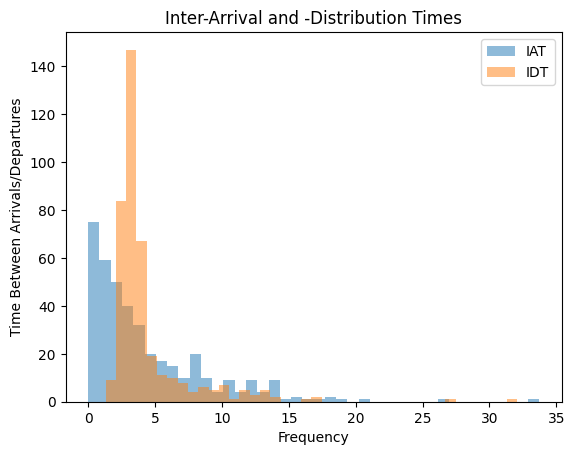

In [13]:
#visualizing the IAT and IDT distributions 

plt.hist(IAT, 40, label='IAT', alpha=.5) 
plt.hist(IDT, 40, label='IDT', alpha=.5)
plt.xlabel("Frequency")
plt.ylabel('Time Between Arrivals/Departures')
plt.legend()
plt.title('Inter-Arrival and -Distribution Times')
plt.show()

# Problem 2 (50% for CSC 446, 25% for CSC 546)

1. Apply the Chi-square test to the recorded 400 customers in Problem 1 to test the hypothesis that the customer arrival
process follows a Poisson process, using the level of significance α = 0.05. 

$\textbf{Ans:} $

For arrival counts following a Poisson process, it can be shown that the inter-arrival times follow an exponential distribution. Thus, in order to test whether the customer arrival process follows a Poisson process, we can test whether the inter-arrival times follow an exponential distribution with parameter $\lambda = \frac{1}{Mean IAT} = 1/4.5$.

Our Hypotheses are then:

$H_0$: The random variable, IAT, is exponentially distributed.
    
$H_1$: The random variable, IAT, is not exponentially distributed.

Referring to Table 9.5 (Discrete-Event System Simulation, 4th Ed., J. Banks), n=400, so choose k such that $\sqrt{n} < k < n/5.$ Choose k=42. This way, when comparing to the critical value, we will be comparing against a chi-sqare dist with 42-1-1=40 degrees of freedom.
Thus each class interval will have an equal probability of $p=1/42.$

The Chi-sqare value for the 400 inter-arrival times following this assumed exponential distribution was calculated in the code cell above to be:

$\chi^2_0 = 39.631579$

From Table A.6, the corresponding chi-sqare distribution has a critical value of $\chi^2_{0.05,40} = 55.8$ (Discrete-Event System Simulation, 4th Ed., J. Banks).

Thus,
$39.631579 < 55.8 $
$\chi^2_0 < \chi^2_{0.05,40}$

Therefore the Null Hypothesis, $H_0$ can be not rejected. That is, The random variable IAT is exponentially distributed, and thus the Arrival Process follows a Poisson Process.




2. Apply the Chi-square test to the recorded 400 customers in Problem 1 to test the hypothesis that the customer depature
process follows a Poisson process, using the level of significance α = 0.05. 

$\textbf{Ans:}$ 

Similar to above, we can test that the customer departure follows a Poisson by testing if the inter-departure times follow an exponential distribution.
From Little's Law, $L=\lambda \omega$ states that for a stable system, the mean departure rate is equal to the mean arrival rate. Thus the mean inter-departure time is equal to the mean inter-arrival time, $\lambda_D = 1/(Mean IDT) = 1/4.5$

Our Hypotheses are then:

$H_0$: The random variable, IDT, is exponentially distributed.
    
$H_1$: The random variable, IDT, is not exponentially distributed.

The Chi-sqare value for the 400 inter-arrival times following this assumed exponential distribution was calculated in the code cell above to be:

$\chi^2_0 = 702.157895$

From Table A.6, the corresponding chi-sqare distribution has a critical value of $\chi^2_{0.05,40} = 55.8$ (Discrete-Event System Simulation, 4th Ed., J. Banks).

Thus,
$702.157895 > 55.8 $
$\chi^2_0 > \chi^2_{0.05,40}$

Therefore the Null Hypothesis, $H_0$ is rejected. That is, The random variable IAT does not follow an exponential distribution, and the departure process does not follow a Poisson process. This is intuitively supported by quickly visualizing the distributions of inter-arrival and inter-departure times, as seen in the histogram above. The IDT distribution does not appear to follow an exponential curve.


3. What is your conclusion after the statistical test?

$\textbf{Ans:}$


The statistical tests did not reject the hypothesis that customer arrivals followed a Poisson process, and it did reject the hypothesis that customer departures followed a Poisson process. This implies that customer departures follow a different distribution; this is additionally supported by the visualization of the inter-departure time distribution, which does not appear to follow an exponential curve.

This is expected, as the time between two departures, $D_i$ and $D_{i+1}$ must be at least the service time of customer $i$. So the IDT distribution will not be completely random, as is implied by an exponential distribution. Although the IDT and IAT (and thus customer arrival and departure processes) distributions are not of the same type, the mean arrival rate $\lambda_A$ and the mean departure rate $\lambda_D$ are still equal, as stated by Little's Law.


**Hint: You can use inter-arrival times test for Poisson process: You can examine the inter-arrival times between successive events and check if they follow an exponential distribution. If the inter-arrival times follow an exponential distribution, then the arrival process can be considered a Poisson process.**


# End of Problem 2


# Problem 3 (CSC 546 only, 25% for CSC 546)

Change the service times to exponentially distributed with mean value of 3.2. Run your simulation to generate 400 customers, and and record their arrival times, departure times, service times, and waiting times using the same format as in Problem 1.


1. Apply the Chi-square test to the recorded customers to test the hypothesis that the customer arrival
process follows a Poisson process, using the level of significance α = 0.05. 

Ans: Write your answer here. 

2. Apply the Chi-square test to the recorded customers to test the hypothesis that the customer depature
process follows a Poisson process, using the level of significance α = 0.05. 

Ans: Write your answer here. 


3. What is your conclusion after the statistical test?

Ans: Write your answer here. 
**Hint: You can use inter-arrival times test for Poisson process: You can examine the inter-arrival times between successive events and check if they follow an exponential distribution. If the inter-arrival times follow an exponential distribution, then the arrival process can be considered a Poisson process.**

# End of Problem 3
